# Proiect la Disciplina Inteligență Artificială

Stundeți: **Ciupercă Radu-Mihail și Mihai Vlad-Andrei**</br>
Prof. Coorodnator: **Luchici Andrei**</br>
An Univesitar: **2022-2023**</br>

In [ ]:
import gymnasium as gym
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pygame

import os
import sys
import pickle
from multiprocessing import Pool
from random import randint
from typing import Any



import neat

from src.models import Fitness, NeatModel
from src.preprocessing import RayFrameParser


### Environment-ul de baza

In [ ]:
env = gym.make('CarRacing-v2', render_mode="human")

observation = env.reset()
env.render() 
rewardsum = 0  
previous_error = 0    
done = False
sample_steps = 1000;

while(sample_steps != 0):
    action = env.action_space.sample()
    observation, reward, done, info, empty = env.step(action)
    rewardsum = rewardsum + reward
    sample_steps = sample_steps - 1
print("Scor Final: ", rewardsum)
env.close()

#### Observatiile primite din Environment-ul de baza
![Schema ce exemplifica functionarea unui environment de RL](assets/agentSchema.png)

**Actiunile din environment**

In [ ]:
line = "________________________________________________________________________________________________________________________"
print(line)
print(f"Ultima actiune a agentului: {action}")
print(line)

In [ ]:
print(line)
print(f"Directia de virare: {action[0]}")
print("O valoarea apropiata de -1 inseamna ca masina a virat spre stanga iar o valoare aproape de 1 insemna ca masina a virat spre dreapta")
print(line)
print(f"Starea de apasare a pedalei de acceleratie: {action[1]}")
print("0 nu este apasata deloc | 1 este apasata la maxim")
print(line)
print(f"Starea de apasare a pedalei de frana: {action[2]}")
print("0 nu este apasata deloc | 1 este apasata la maxim")
print(line)

**Observatiile din environment**

In [7]:
observation

array([[[100, 202, 100],
        [100, 205, 100],
        [100, 228, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 202, 100],
        [100, 203, 100],
        [100, 228, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       [[100, 202, 100],
        [100, 202, 100],
        [100, 226, 100],
        ...,
        [100, 202, 100],
        [100, 202, 100],
        [100, 202, 100]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

**Interprertarea observatiilor**

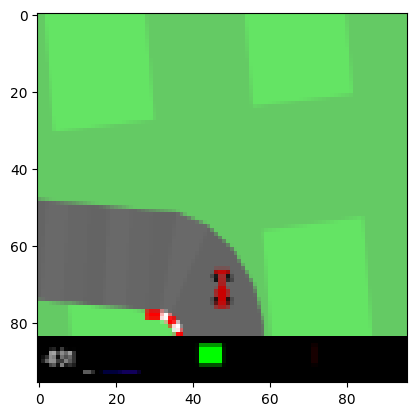

In [8]:
plt.imshow(observation)
plt.show()

### Rularea Jocului cu Input de la jucator

**Definim functia pentru a putea inregistra input-ul**

In [9]:
a = np.array([0.0, 0.0, 0.0])
def register_input():
    global quit, restart
    for event in pygame.event.get():
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_LEFT:
                a[0] = -1.0
            if event.key == pygame.K_RIGHT:
                a[0] = +1.0
            if event.key == pygame.K_UP:
                a[1] = +1.0
            if event.key == pygame.K_DOWN:
                a[2] = +0.8  # set 1.0 for wheels to block to zero rotation
            if event.key == pygame.K_RETURN:
                restart = True
            if event.key == pygame.K_ESCAPE:
                quit = True

        if event.type == pygame.KEYUP:
            if event.key == pygame.K_LEFT:
                a[0] = 0
            if event.key == pygame.K_RIGHT:
                 a[0] = 0
            if event.key == pygame.K_UP:
                a[1] = 0
            if event.key == pygame.K_DOWN:
                 a[2] = 0

        if event.type == pygame.QUIT:
            quit = True

**Re-initializam Environment-ul**

In [10]:
env = gym.make('CarRacing-v2', render_mode="human")

quit = False
while not quit:
    env.reset()
    total_reward = 0.0
    steps = 0
    restart = False
    while True:
        register_input()
        s, r, terminated, truncated, info = env.step(a)
        if terminated or truncated or restart or quit:
            break
env.close()

### Utilizarea unui algoritm matematic (Sistem Expert)

![OpenCV1](assets/opencv1.png)

In [11]:
def green_mask(observation):
    hsv = cv2.cvtColor(observation, cv2.COLOR_BGR2HSV)
    mask_green = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))

    ## slice the green
    imask_green = mask_green>0
    green = np.zeros_like(observation, np.uint8)
    green[imask_green] = observation[imask_green]
    return(green)

In [12]:
def gray_scale(observation):
    gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
    return gray

In [13]:
def blur_image(observation):
    blur = cv2.GaussianBlur(observation, (5, 5), 0)
    return blur

In [14]:
def canny_edge_detector(observation):
    canny = cv2.Canny(observation, 50, 150)
    return canny

![OpenCV1](assets/opencv2.png)

In [15]:
def find_error(observation,previous_error):

  cropped = observation[63:65, 24:73]

  green = green_mask(cropped)
  grey  = gray_scale(green)
  blur  = blur_image(grey)
  canny = canny_edge_detector(blur)


  nz = cv2.findNonZero(canny)

  mid  = 24
  
  # some further adjustments obtained through trail and error
  if nz[:,0,0].max() == nz[:,0,0].min():
    if nz[:,0,0].max() <30 and nz[:,0,0].max()>20:
      return previous_error
    if nz[:,0,0].max() >= mid:
      return(-15)
    else:
      return(+15)
  else:
    return(((nz[:,0,0].max() + nz[:,0,0].min())/2)-mid)

In [16]:
def pid(error,previous_error):
    Kp = 0.02
    Ki = 0.03
    Kd = 0.2

    steering = Kp * error + Ki * (error + previous_error) + Kd * (error - previous_error)

    return steering

In [18]:
import gymnasium as gym

env = gym.make('CarRacing-v2', render_mode="human")

observation = env.reset()
env.render() 
rewardsum = 0  
previous_error = 0    

for x in [1,0]*500:      
  
    try:
      error = find_error(observation,previous_error)
    except:
      error = -15
      print("Eroare peste 15 ")
      pass

    steering = pid(error,previous_error)
   
    action = (steering,x,0)

    observation, reward, done, info, empty = env.step(action)
    previous_error =error
    rewardsum = rewardsum +reward

    if done :
      env.close()
      break
    
print("Scor final: ", rewardsum)
env.close()

Eroare peste 15 
Scor final:  662.6582278480934


In [19]:
cropped = observation[63:65, 24:73]

In [20]:
green_cropped = green_mask(cropped)
grey_cropped  = gray_scale(green_cropped)
blur_cropped  = blur_image(grey_cropped)
canny_cropped = canny_edge_detector(blur_cropped)


green_screen = green_mask(observation)
grey_screen  = gray_scale(green_screen)
blur_screen  = blur_image(grey_screen)
canny_screen = canny_edge_detector(blur_screen)


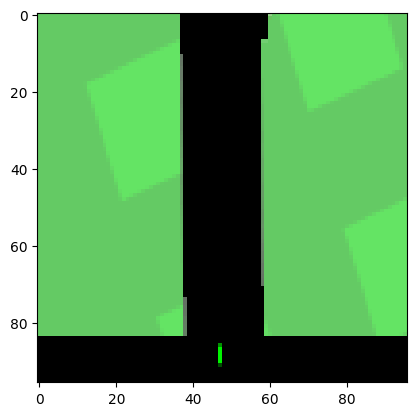

<Figure size 640x480 with 0 Axes>

In [24]:
plt.imshow(green_screen)
plt.show()
plt.savefig("green_screen.png") #save as png

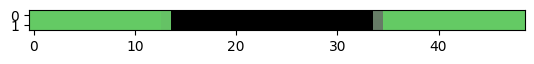

In [25]:
plt.imshow(green_cropped)
plt.show()

**Aplicare Masca Verde**

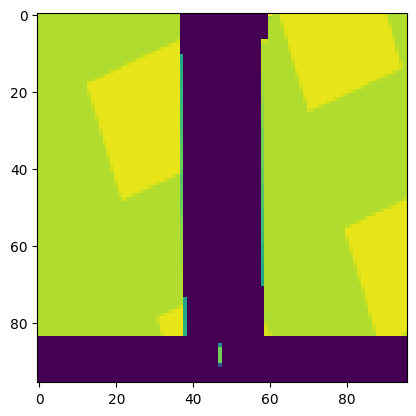

In [26]:
plt.imshow(grey_screen)
plt.show()

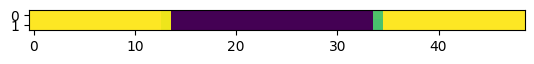

In [27]:
plt.imshow(grey_cropped)
plt.show()

**Aplicare Masca Grey**

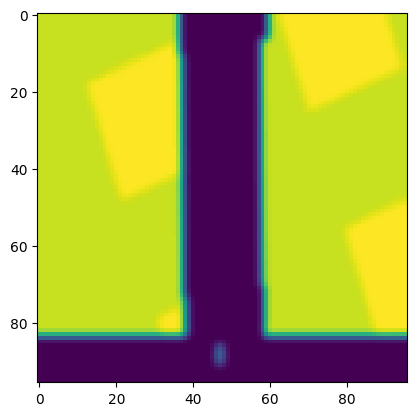

In [28]:
plt.imshow(blur_screen)
plt.show()

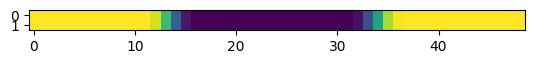

In [29]:
plt.imshow(blur_cropped)
plt.show()

**Aplicare Masca Blur**

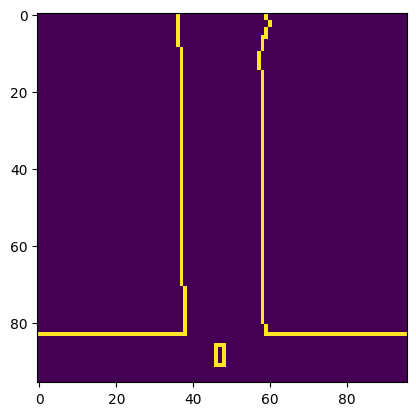

In [30]:
plt.imshow(canny_screen)
plt.show()

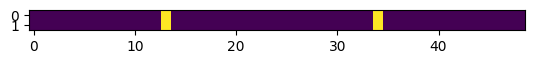

In [31]:
plt.imshow(canny_cropped)
plt.show()

**Aplicare Masca Canny**

## Utilizarea unui algoritm de machine learning (NEAT)

### Algoritmii Genetici
![Imagine cu oamenii preistoricii care au evoluat](assets/evolutie.jpg)

Pentru a intelege algoritmul NEAT este nevoie ca mai intai sa intelegem algoritmii genetici de baza, deoarece acestia stau la baza algoritmului mai sus mentionat

![Slide Algoritmi Evolutivi](assets/Algoritmii_Evolutivi.png)

#### ALGORITMUL N.E.A.T.

![Algoritmul NEAT](assets/neat.png)

In [32]:
NEAT_CONFIG_PATH = "neat_config_ray"

### Etapa de Atrenare

In [33]:
n_steps = 700
def eval_genomes(genomes, config):
    parser = RayFrameParser()
    fitness = Fitness(randint(0, 1_000_000), n_steps, parser)
    models = [NeatModel(id, genome, config) for id, genome in genomes]
    p = Pool(20)
    fitness_value = p.map(fitness, models)
    for i in range(len(models)):
        models[i].genome.fitness = fitness_value[i]

In [34]:
def save(genome, path: str):
    with open(path, "wb") as f:
        pickle.dump(genome, f)
        f.close()

In [35]:
def run(config_file, path: str):
    
    config = neat.Config(
        neat.DefaultGenome,
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        config_file,
    )
    
    p = neat.Population(config)
    print(p)

    
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)

    winner = p.run(eval_genomes, 1)
    save(winner, path)

In [36]:
parser = RayFrameParser()

In [38]:
run(NEAT_CONFIG_PATH, "modele/classModel.pkl")


 ****** Running generation 0 ****** 

Population's average fitness: 16.10514 stdev: 49.85532
Best fitness: 345.80756 - size: (3, 20) - species 1 - id 97
Average adjusted fitness: 0.042
Mean genetic distance 2.382, standard deviation 0.418
Population of 100 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    76    345.8    0.042     0
     2    0    24       --       --     0
Total extinctions: 0
Generation time: 27.016 sec


### Etapa de testare

## Model Antrenat la clasa

In [40]:
parser = RayFrameParser()
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        NEAT_CONFIG_PATH)



with open("C:/Users/raduc/repos/PROIECT_FINAL_DUBLU_FINAL/modele/classModel.pkl", "rb") as f:
    genome = pickle.load(f)

model = NeatModel(-1, genome, config)
fitness = Fitness(randint(0, 1_000_000), 2000, parser)
print(fitness(model, display=True))

321.91702127659465


## Model antrenat anterior 10 de membri 1 Hidden Layer

In [41]:
parser = RayFrameParser()
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        NEAT_CONFIG_PATH)



with open("C:/Users/raduc/repos/PROIECT_FINAL_DUBLU_FINAL/modele/1Gen_10Pop_1HL.pkl", "rb") as f:
    genome = pickle.load(f)

model = NeatModel(-1, genome, config)
fitness = Fitness(randint(0, 1_000_000), 2000, parser)
print(fitness(model, display=True))

54.20801393728195


## Model antrenat anterior 500 de membri 1 Hidden Layer

In [42]:
parser = RayFrameParser()
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        NEAT_CONFIG_PATH)



with open("C:/Users/raduc/repos/PROIECT_FINAL_DUBLU_FINAL/modele/1Gen_500Pop_1HL.pkl", "rb") as f:
    genome = pickle.load(f)

model = NeatModel(-1, genome, config)
fitness = Fitness(randint(0, 1_000_000), 2000, parser)
print(fitness(model, display=True))

647.5731629392867


## Model antrenat anterior 200 de membri 8 Hidden Layer

In [43]:

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                        neat.DefaultSpeciesSet, neat.DefaultStagnation,
                        NEAT_CONFIG_PATH)



with open("C:/Users/raduc/repos/PROIECT_FINAL_DUBLU_FINAL/modele/100_Generari.pkl", "rb") as f:
    genome = pickle.load(f)

model = NeatModel(-1, genome, config)
fitness = Fitness(randint(0, 1_000_000), 2000, parser)
print(fitness(model, display=True))

857.2999999999793


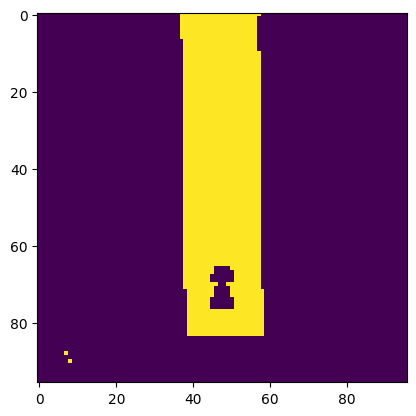

In [44]:
parser = RayFrameParser()
binaryzeWorld = parser._binarizeWorld(observation)

plt.imshow(binaryzeWorld)
plt.show()

## Raze pana la iarba

![raze](assets/rays.png)

## Raze pana la drum

![Raze](assets/rays_road.png)

# BONUS :)

In [45]:
import ctypes
ctypes.windll.user32.SystemParametersInfoW(20, 0, "C:/Users/raduc/Pictures/fit.jpg" , 0)

1

In [46]:
import ctypes
ctypes.windll.user32.SystemParametersInfoW(20, 0, "C:/Users/raduc/Pictures/fit.jpg" , 0)

1

In [47]:
cap ='C:/Users/raduc/repos/PROIECT_FINAL_DUBLU_FINAL/50_de_bani.mp4'

In [48]:
cap = 'C:/Users/raduc/repos/PROIECT_FINAL_DUBLU_FINAL//Monaco.mp4'

In [49]:
import subprocess
subprocess.call(['start', cap], shell=True)  # Pentru sistemele Windows

0